Part 4: Homography + RANSAC
Q1. Load im01.jpg and im02.jpg. Based on SIFT, find matches between the two images. Show all the matches
the matches are shown below

In [2]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as  linalg
image_1 = cv2.imread('im01.jpg')
image_2 = cv2.imread('im02.jpg')
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
print(image_1.shape, image_2.shape)
sift = cv2.SIFT_create()
kp_1, dp_1 = sift.detectAndCompute(image_1, None)
kp_2, dp_2 = sift.detectAndCompute(image_2, None)

def key_point_match(kp_1, kp_2, dp_1, dp_2):
    key_point_match_12=[]
    key_point_match_21=[]
    match_pairs=[]
    for i in range(len(kp_1)):
        temp_list=[]
        for j in range(len(kp_2)):
            temp=dp_1[i]-dp_2[j]
            temp=np.sqrt(sum(temp**2))
            temp_list.append((temp,j))
        temp_list.sort(key=lambda x: x[0])
        key_point_match_12.append((int(temp_list[0][0]), temp_list[0][1], i))
    for i in range(len(kp_2)):
        temp_list=[]
        for j in range(len(kp_1)):
            temp=dp_2[i]-dp_1[j]
            temp=np.sqrt(sum(temp**2))
            temp_list.append((temp,j))
        temp_list.sort(key=lambda x: x[0])
        key_point_match_21.append((int(temp_list[0][0]), temp_list[0][1], i))
    for i,(d_12,match_2,k_1) in enumerate(key_point_match_12):
        for j,(d_21,match_1,k_2) in enumerate(key_point_match_21):
            if match_2==k_2 and match_1==k_1:
                match_pairs.append((d_12, match_2, k_1))
    return match_pairs


    

(480, 640, 3) (480, 640, 3)


401


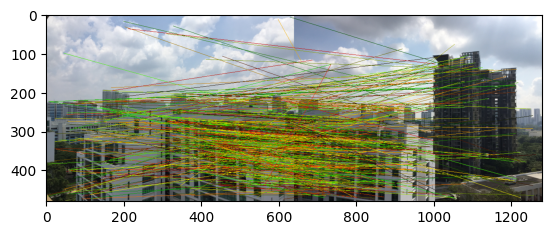

In [6]:
image_show= np.zeros([image_1.shape[0],image_1.shape[1]+image_2.shape[1],3],dtype=np.int32)
image_show[:image_1.shape[0],:image_1.shape[1]]=image_1
image_show[:image_1.shape[0],image_1.shape[1]:]=image_2

matched_points= key_point_match(kp_1,kp_2,dp_1,dp_2)
for matched_point in matched_points:
    (_,k_2,k_1)= matched_point
    color= np.random.randint(0, 255, 3, dtype=np.int32)
    cv2.line(image_show,(int(kp_1[k_1].pt[0]),int(kp_1[k_1].pt[1])),(image_1.shape[1]+(int(kp_2[k_2].pt[0])),int(kp_2[k_2].pt[1])),(int(color[0]),int(color[1]),3),1)
plt.imshow(image_show)
print (len(matched_points))

Q2. Compute the best homography matrix using RANSAC, and show all the inlier matches (matches that support your best homography matrix):

In [47]:
def pick_random(matched_point_set):
    """
    return 4 random coordinates pairs
    """
    p_kp_1=[]
    p_kp_2=[]
    random= np.random.randint(0, len(matched_point_set),4)
    for r in random:
        index_1, index_2= matched_point_set[r][2], matched_point_set[r][1]
        p_kp_1.append((int(kp_1[index_1].pt[0]),int(kp_1[index_1].pt[1])))
        p_kp_2.append((int(kp_2[index_2].pt[0]),int(kp_2[index_2].pt[1])))
    return p_kp_1,p_kp_2


def compute_H(points_1, points_2, show_H):
    d=len(points_1)
    A = np.zeros([2*d, 9])
    for index ,(point_1, point_2) in enumerate(zip (points_1, points_2)):
        (y_1, x_1),(y_2, x_2)= point_1, point_2
        A[2*index, :]=[x_1, y_1,1,0,0,0,-x_2*x_1, -x_2*y_1, -x_2]
        A[2*index+1, :]=[0,0,0,x_1,y_1,1,-y_2*x_1, -y_2*y_1, -y_2]
    U, D, V= linalg.svd(A)
    H= V [-1, :].reshape(3,3)
    H = H / H[2, 2]
    if show_H is True:
        print(H)
    return H

def transform_h_2_h(h_1, h_2,cv_p1,cv_p2,show_H,compute,external_H):
    m_list=[]
    n_list=[]
    x,y,z= h_1.shape
    u,v,w= h_2.shape
    if compute is False:
       Matrix_H= external_H
    elif compute is True: Matrix_H= compute_H(cv_p1, cv_p2, show_H)
    corners= [(0,0),(x-1,0),(x-1,y-1),(0,y-1)]
    for corner in corners:
        m,n= corner
        temp= np.dot(Matrix_H,np.array([m, n, 1]))
        temp_m, temp_n,_ =temp/temp[2]
        m_list.append(int(temp_m))
        n_list.append(int(temp_n))
    max_u,max_v,shift_u,shift_v=int(max(m_list)), int(max(n_list)), int (min(m_list)), int(min(n_list)) 
    print(max_u,max_v,shift_u,shift_v)
    image= np.zeros([max_u-shift_u,max_v-shift_v,3],dtype=np.uint8)
    row=0
    while row<x:
        col=0
        while col < y:
            temp= np.dot(Matrix_H, np.array([row, col, 1]))
            temp_x, temp_y,_= temp/temp[2]
            if shift_u<=temp_x<max_u and shift_v<=temp_y<max_v:
                image[int(temp_x)-shift_u,int(temp_y)-shift_v,:]= h_1[int(row), int(col),:]
            col+=0.2
        row+=0.2
    return image, shift_u,shift_v
   
def Ransac(matched_point_set,image1,image2,diraction):
    global threshold, iterations
    image_line=np.zeros([image1.shape[0],image1.shape[1]+image2.shape[1],3],dtype=np.int32)
    image_line[:image1.shape[0],:image1.shape[1]]=image1
    image_line[:image1.shape[0],image1.shape[1]:]=image2
    in_line=-1
    for iteration in range (iterations):
        p_1,p_2= pick_random(matched_point_set)
        if diraction ==2:
           Matrix_H= compute_H(p_2, p_1, False)
        if diraction ==1:
           Matrix_H= compute_H(p_1, p_2, False)
        candidates=[]
        for match_point in matched_point_set:
            (_, k_2, k_1) = match_point
            y_1,x_1= int(kp_1[k_1].pt[0]), int(kp_1[k_1].pt[1])
            y_2,x_2= int(kp_2[k_2].pt[0]), int(kp_2[k_2].pt[1])
            if diraction==2:
               temp= np.dot(Matrix_H, [x_2,y_2,1])
               x_h, y_h, _ = temp/temp[2]
               diff= (x_h-x_1)**2+(y_h-y_1)**2
            if diraction==1:
               temp= np.dot(Matrix_H, [x_1,y_1,1])
               x_h, y_h, _ = temp/temp[2]
               diff= (x_h-x_2)**2+(y_h-y_2)**2
            candidates.append((k_2, k_1, np.sqrt(diff)))
        new_candidates= list (filter(lambda x: x[2]<=threshold,candidates))
        if len(new_candidates)>in_line:
           in_line= len(new_candidates)
           inline_match=new_candidates
           inline_H= Matrix_H
        
    for i in inline_match:
        (k_2,k_1,_)=i
        color= np.random.randint(0, 255, 3, dtype=np.int32)
        cv2.line(image_line,(int(kp_1[k_1].pt[0]),int(kp_1[k_1].pt[1])),(image_1.shape[1]+(int(kp_2[k_2].pt[0])),int(kp_2[k_2].pt[1])),(int(color[0]),int(color[1]),3),1)
        

    return image_line, inline_match, inline_H 


[[ 8.21044354e-01 -2.09697061e-01  2.56096269e+01]
 [ 2.97408921e-02  4.48478231e-01  2.97338130e+02]
 [-1.35572395e-05 -8.04641807e-04  1.00000000e+00]]


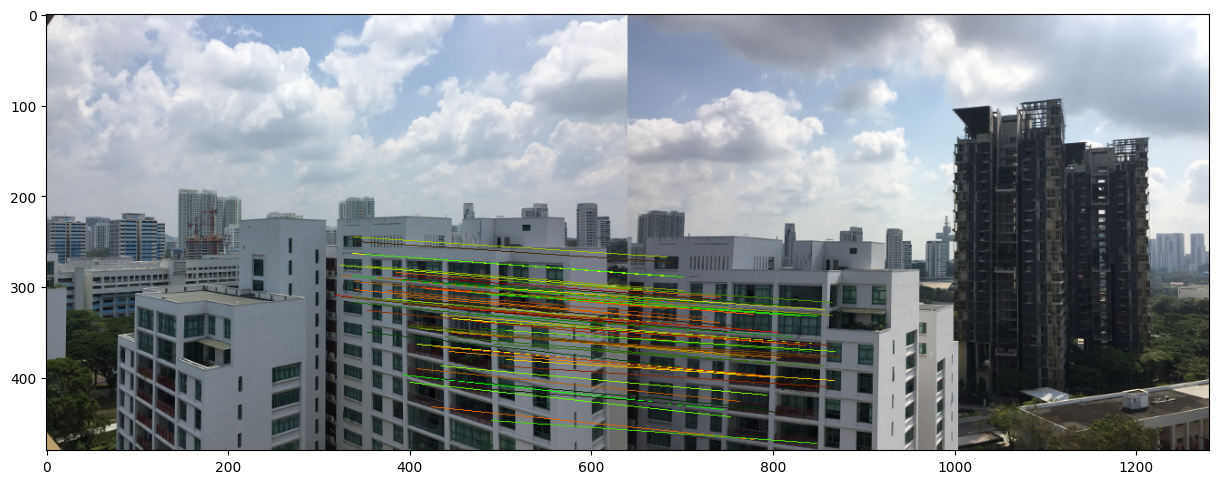

In [52]:
threshold,iterations=0.7, 20000
image_inline, inline_match, H=Ransac(matched_points,image_1,image_2,2)
print(H)
plt.figure(figsize=(15,15))
plt.imshow(image_inline)


594 1247 -223 297


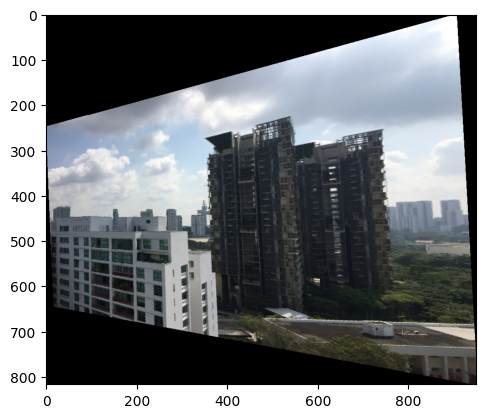

In [53]:
len(inline_match)
image_2_1, shift_h, shift_w=transform_h_2_h(image_2,image_1,None,None,False,False,H)
plt.imshow(image_2_1)

Q3. 1. Stitch the images together using the best homography matrix and show the result:
transform img_02 to img_01

(1074, 1590, 3)


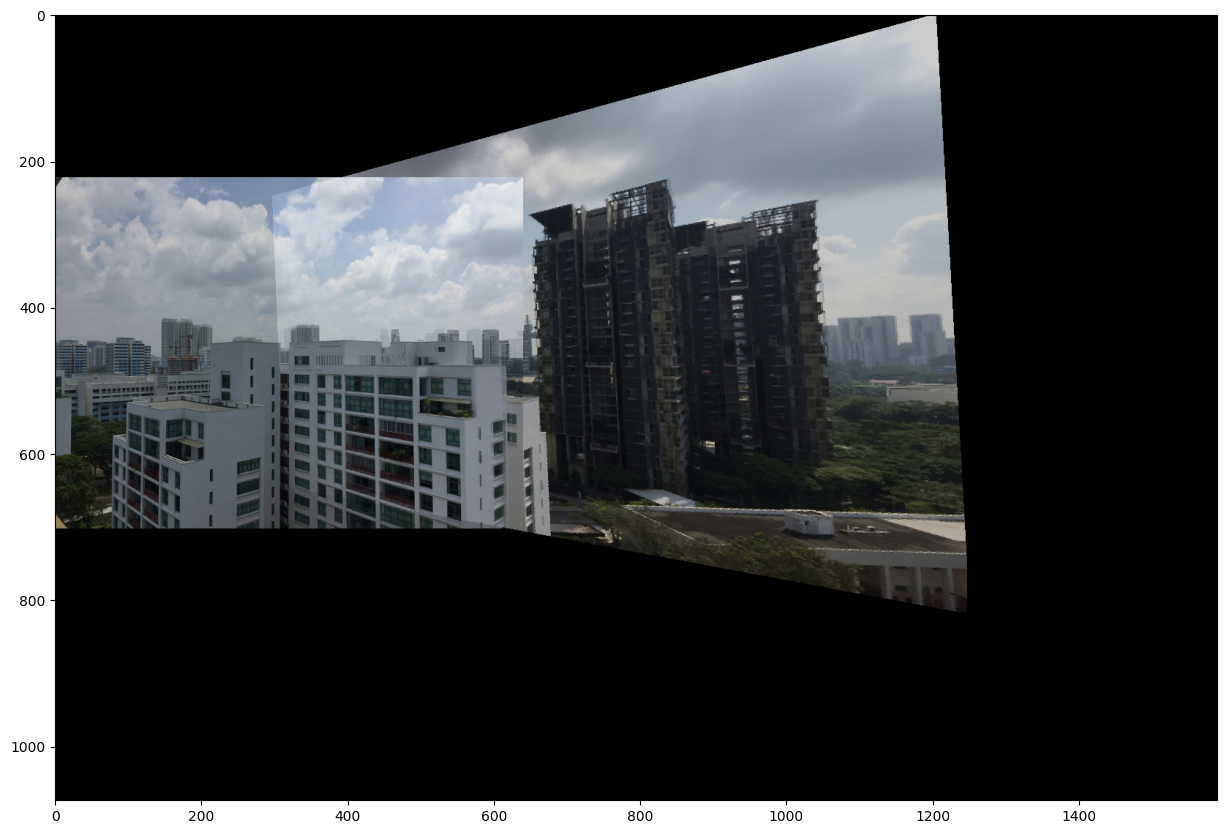

In [54]:
def stitch_image(image_1, image_stitched,shift_h, shift_w):
    h, w, _ = image_1.shape
    h_s, w_s, _=image_stitched.shape
    h_res, w_res= h-abs(shift_h)+h_s, w+w_s
    image_res = np.zeros((h_res, w_res, 3), dtype=np.uint8)
    print(image_res.shape)
    image_res[:h_s, abs(shift_w):w_s+abs(shift_w) ] = 0.8*image_stitched+0.2*image_res[:h_s, abs(shift_w):w_s+abs(shift_w) ]
    image_res[abs(shift_h):abs(shift_h)+h,:w]= 0.8*image_1+0.2*image_res[abs(shift_h):abs(shift_h)+h,:w]
    return image_res
image_res=stitch_image(image_1, image_2_1, shift_h, shift_w) 
plt.figure(figsize=(15,15))
plt.imshow(image_res)

Q3.2. Transform img_01 to img_02

[[ 1.77166451e+00  5.86061617e-01 -2.01621455e+02]
 [-1.42642025e-01  2.25921319e+00 -6.56798376e+02]
 [-3.18312383e-04  2.04162537e-03  1.00000000e+00]]
763 341 -201 -855


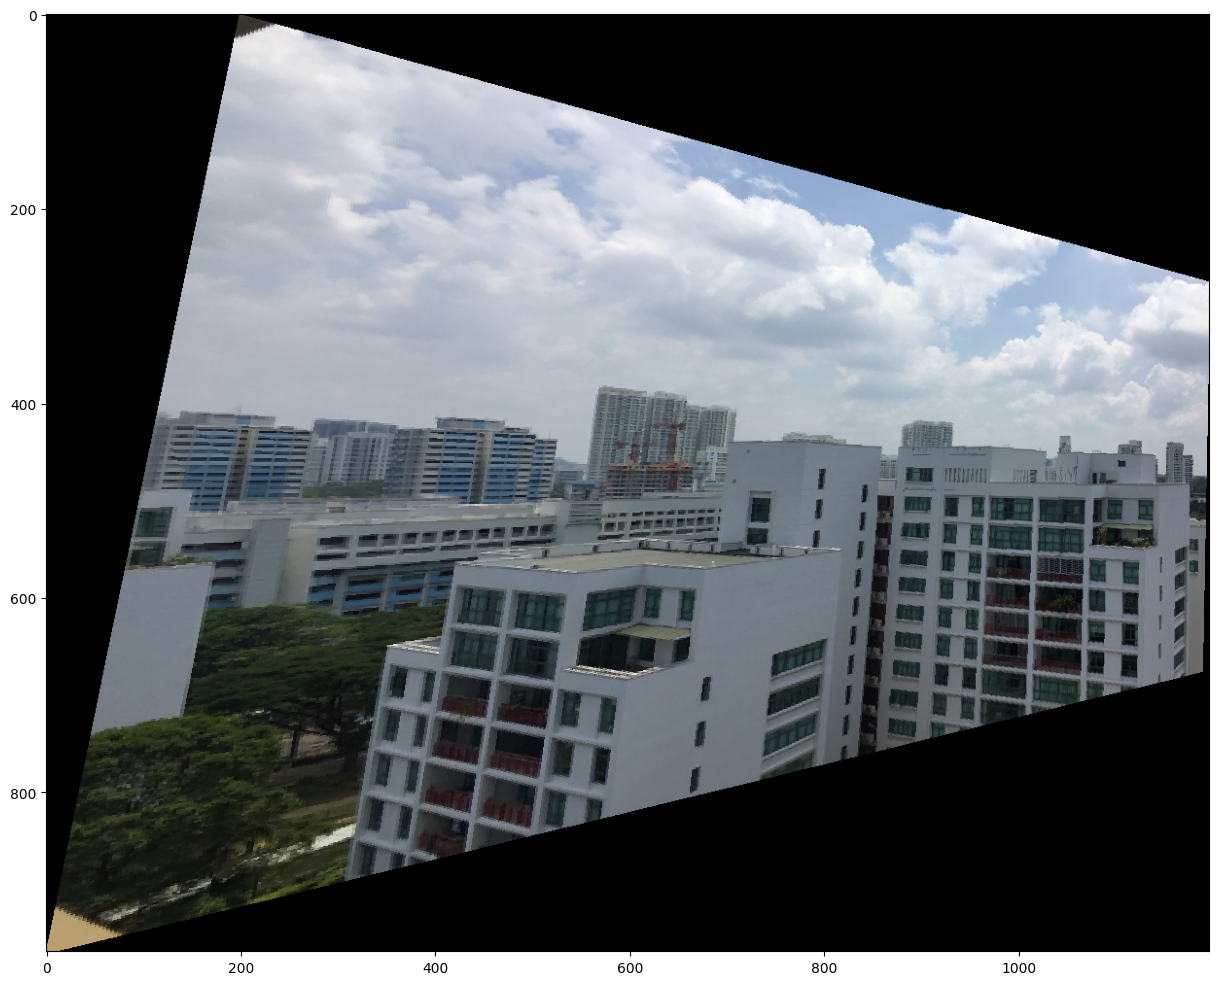

In [56]:
threshold,iterations=0.8, 20000
image_inline2, inline_match2, H2=Ransac(matched_points,image_1,image_2,1)
print(H2)
plt.figure(figsize=(15,15))
# plt.imshow(image_inline)
image_1_2, shift_h2, shift_w2=transform_h_2_h(image_1,image_2,None,None,False,False,H2)
plt.imshow(image_1_2)

Sticthing image_01 to image_02

(1243, 2691, 3)


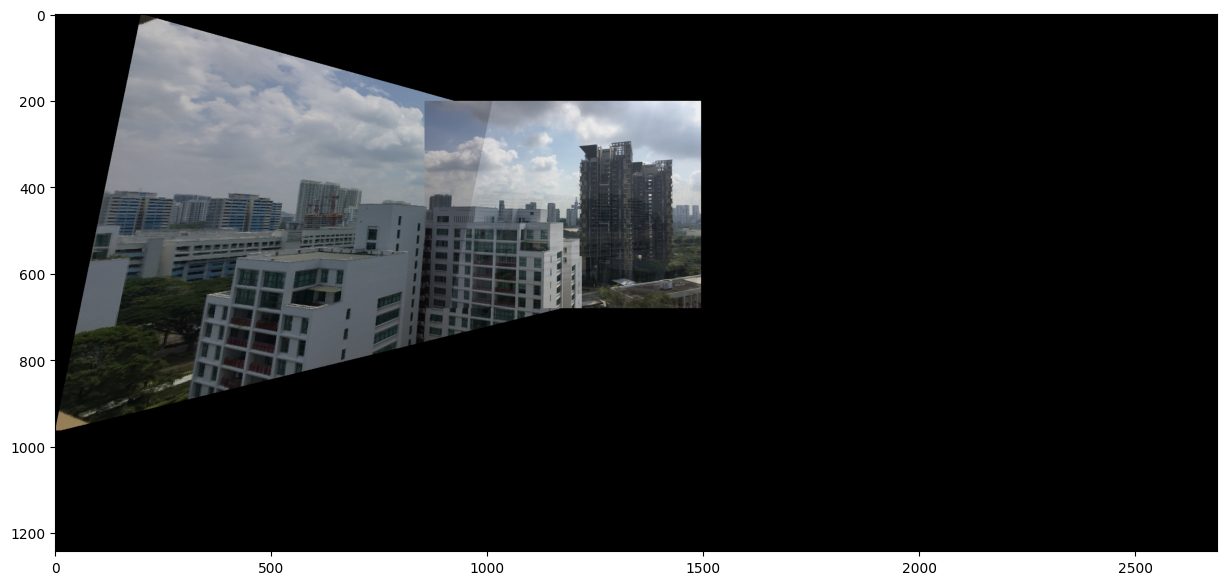

In [60]:
def stitch_image(image_1, image_stitched,shift_h, shift_w):
    h, w, _ = image_1.shape
    h_s, w_s, _=image_stitched.shape
    h_res, w_res= h-abs(shift_h)+h_s, w+w_s+abs(shift_w)
    image_res = np.zeros((h_res, w_res, 3), dtype=np.uint8)
    print(image_res.shape)
    image_res[:h_s, :w_s ] = 0.8*image_stitched+0.2*image_res[:h_s, abs(shift_w):w_s+abs(shift_w)]
    image_res[abs(shift_h):abs(shift_h)+h,abs(shift_w):abs(shift_w)+w]= 0.8*image_1+0.2*image_res[abs(shift_h):abs(shift_h)+h,:w]
    return image_res
image_res=stitch_image(image_2, image_1_2, shift_h2, shift_w2) 
plt.figure(figsize=(15,15))
plt.imshow(image_res)